# Consumer expenditure categorization

### Why relational learning matters

This example demonstrates how powerful a real relational learning algorithm can be. Based on a public-domain dataset on consumer behavior, we use a propostionalization algorithm to predict whether purchases were made as a gift. We show that with relational learning, we can get an AUC of over 90%. The generated features would have been impossible to build by hand or by using brute-force approaches.

Summary:

- Prediction type: __Classification model__
- Domain: __Retail__
- Prediction target: __If a purchase is a gift__ 
- Source data: __Relational data set, 4 tables__
- Population size: __398.895__

_Author: Patrick Urbanke_

# Background

Relational learning is one of the most underappreciated fields of machine learning. Even though relational learning is very relevant to many real world data science projects, many data scientists don't even know what relational learning is. 

There are many subdomains of relational learning, but the most important one is extracting features from relational data: Most business data is relational, meaning that it is spread out over several relational tables. However, most machine learning algorithms require that the data be presented in the form of a single flat table. So we need to extract features from our relational data. Some people also call this data wrangling.

Most data scientists we know extract features from relational data manually or by using crude, brute-force approaches (randomly generate thousands of features and then do a feature selection). This is very time-consuming and does not produce good features.

### The challenge

The Consumer Expenditure Data Set is a public domain data set provided by the American Bureau of Labor Statistics (https://www.bls.gov/cex/pumd.htm). It includes the diary entries, where American consumers are asked to keep diaries of the products they have purchased each month.

These consumer goods are categorized using a six-digit classification system the UCC. This system is hierarchical, meaning that every digit represents an increasingly granular category.

For instance, all UCC codes beginning with ‘200’ represent beverages. UCC codes beginning with ‘20011’ represents beer and ‘200111’ represents ‘beer and ale’ and ‘200112’ represents ‘nonalcoholic beer’ (https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx).

The diaries also contain a flag that indicates whether the product was purchased as a gift. The challenge is to predict that flag using other information in the diary entries.

This can be done based on the following considerations:

1. Some items are _less likely to be purchased as gifts_ than others (for instance, it is unlikely that toilet paper is ever purchased as a gift).

2. Items that diverge from the _usual consumption patterns_ are more likely to be gifts.

In total, there are three tables which we find interesting:

1. EXPD, which contains information on the _consumer expenditures_, including the target variable GIFT.

2. FMLD, which contains socio-demographic information on the _households_.

3. MEMD, which contains socio-demographic information on each _member of the households_.


### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

In [1]:
import datetime
import os
from urllib import request
import time
import zipfile

import matplotlib.pyplot as plt
%matplotlib inline

import getml
from getml import data 
from getml import engine 
from getml import feature_learning 
from getml import hyperopt
from getml.feature_learning import loss_functions
from getml.pipeline import Pipeline
from getml.data import placeholder
from getml.data import roles 
from getml.pipeline import scores
from getml import predictors
from getml import preprocessors

## 1. Loading data

### 1.1 Download from source

First, we need to download and unzip the data. For your convenience, we have scripted this.

If you want to download them manually, you can use this link: https://www.bls.gov/cex/pumd.htm.

We will use the diary CSV files for the year 2015. There are more years you can use, but we will limit ourselves to this one year for now.

In [2]:
fname = "diary15.zip"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://www.bls.gov/cex/pumd/data/comma/diary15.zip", 
        "diary15.zip"
    )

RAW_DATA_FOLDER = "diary15/"

if not os.path.exists(RAW_DATA_FOLDER):
    with zipfile.ZipFile(fname, 'r') as dzip: 
        dzip.extractall() 

We now set the project.

In getML, every data frame and model is tied to a project. If you change the project, then the memory is flushed and all unsaved changes are lost (but don't worry, models are saved automatically).

In [3]:
engine.set_project("consumer_expenditures")


Connected to project 'consumer_expenditures'


### 1.2 Prepare data for getML

We load the data directly into getML data frames. There are other ways to do this, such as using pandas or loading the data into a data base first. But we will us this approach.

In [4]:
# -----------------------------------------------------------------------------
# Load EXPD

expd_fnames = [
    RAW_DATA_FOLDER + "expd151.csv",
    RAW_DATA_FOLDER + "expd152.csv",
    RAW_DATA_FOLDER + "expd153.csv",
    RAW_DATA_FOLDER + "expd154.csv"
]

# The sniffer will interpret NEWID and UCC
# as a numeric column. But we want it
# to be treated as a string.
expd_roles = {"unused_string": ["UCC", "NEWID"]}

df_expd = data.DataFrame.from_csv(
    fnames=expd_fnames,
    name="EXPD",
    roles=expd_roles
)

df_expd

Name,ALLOC,COST,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO,EXPNMO_,EXPNYR,EXPNYR_,UCC,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,3.89,2,2,4,D,1,D,01,D,2015,D,010210,03111041
1,1,4.37725,2,2,4,D,1,D,01,D,2015,D,060110,03111041
2,1,3.58275,2,2,4,D,1,D,01,D,2015,D,060210,03111041
3,0,5.58,2,2,4,D,1,D,01,D,2015,D,090110,03111041
4,0,1.99,2,2,4,D,1,D,01,D,2015,D,090210,03111041
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412623,0,4.99,2,2,4,D,7,D,12,D,2015,D,550210,03324162
412624,1,11.6549,2,1,3,D,6,D,12,D,2015,D,590230,03324162
412625,1,7.99,2,2,3,D,6,D,12,D,2015,D,660000,03324162


In [5]:
# -----------------------------------------------------------------------------
# Load FMLD

fmld_fnames = [
    RAW_DATA_FOLDER + "fmld151.csv",
    RAW_DATA_FOLDER + "fmld152.csv",
    RAW_DATA_FOLDER + "fmld153.csv",
    RAW_DATA_FOLDER + "fmld154.csv"
]

# The sniffer will interpret NEWID
# as a numeric column. But we want it
# to be treated as a string.
fmld_roles = {"unused_string": ["NEWID"]}

df_fmld = data.DataFrame.from_csv(
    fnames=fmld_fnames,
    name="FMLD",
    roles=fmld_roles
)

df_fmld

Name,INC_RNKM,INC_RNK5,INC_RNK4,INC_RNK3,INC_RNK2,INC_RNK1,INC_RANK,AGE_REF,BLS_URBN,CUTENURE,EARNCOMP,EDUC_REF,FAM_SIZE,FAM_TYPE,FGVX,FINCBEFX,FINLWT21,FIRAX,FJSSDEDX,FPVTX,FRRX,FSS_RRX,FSUPPX,FWAGEX,JFS_AMT,MARITAL1,NO_EARNR,OTHRECX,PERSLT18,PERSOT64,POPSIZE,REF_RACE,SEX_REF,SMSASTAT,STRTMNTH,STRTYEAR,WEEKI,WEEKN,WK_WRKD1,FOODTOT,FOODHOME,CEREAL,BAKEPROD,BEEF,PORK,OTHMEAT,POULTRY,SEAFOOD,EGGS,MILKPROD,OTHDAIRY,FRSHFRUT,FRSHVEG,PROCFRUT,PROCVEG,SWEETS,NONALBEV,OILS,MISCFOOD,FOODAWAY,ALCBEV,SMOKSUPP,PET_FOOD,PERSPROD,PERSSERV,DRUGSUPP,HOUSKEEP,HH_CU_Q,CHILDAGE,INCLASS,CUID,FGVXM,FINCBEFM,FINCBEF1,FINCBEF2,FINCBEF3,FINCBEF4,FINCBEF5,FINCBEFI,FJSSDEDM,FJSSDED1,FJSSDED2,FJSSDED3,FJSSDED4,FJSSDED5,FPVTXM,FRRXM,FS_AMTXI,FSS_RRXM,FSS_RRX1,FSS_RRX2,FSS_RRX3,FSS_RRX4,FSS_RRX5,FSS_RRXI,FSUPPXM,FSUPPX1,FSUPPX2,FSUPPX3,FSUPPX4,FSUPPX5,FSUPPXI,FWAGEXM,FWAGEX1,FWAGEX2,FWAGEX3,FWAGEX4,FWAGEX5,FWAGEXI,JFS_AMTM,JFS_AMT1,JFS_AMT2,JFS_AMT3,JFS_AMT4,JFS_AMT5,OTHINXI,WELFRXI,PICKCODE,HIGH_EDU,FSMPFRMX,FSMPFRX1,FSMPFRX2,FSMPFRX3,FSMPFRX4,FSMPFRX5,FSMPFRXI,FSMPFRXM,INTRDVXI,NETRENTI,OTHREGXI,RETSURVI,ROYESTXI,HISP_REF,AGE_REF_,AGE2,AGE2_,CUTE_URE,DESCRIP,DESCRIP_,EARN_OMP,EDUC0REF,EDUCA2,EDUCA2_,EMPLTYP1,EMPL_YP1,EMPLTYP2,EMPL_YP2,FAM__IZE,FAM__YPE,FGVX_,FINC_EFX,FIRAX_,FJSS_EDX,FPVTX_,FREEMLX,FREEMLX_,FRRX_,FS_MTHI,FS_MTHI_,FSS_RRX_,FSUPPX_,FWAGEX_,HRSPRWK1,HRSP_WK1,HRSPRWK2,HRSP_WK2,JFS_AMT_,JGRCFDMV,JGRC_DMV,JGRCFDWK,JGRC_DWK,JGROCYMV,JGRO_YMV,JGROCYWK,JGRO_YWK,LUMPX,LUMPX_,MARI_AL1,NO_E_RNR,OCCEXPNX,OCCE_PNX,OCCULIS2,OCCU_IS2,OTHINX,OTHINX_,OTHRECX_,PERS_T18,PERS_T64,OCCULIS1,OCCU_IS1,RACE2,RACE2_,REC_FS,REC_FS_,REF__ACE,REGION,SEX_REF_,SEX2,SEX2_,TYPOWND,TYPOWND_,VEHQ,VEHQ_,WEEKI_,WELFRX,WELFRX_,WHYNWRK1,WHYN_RK1,WHYNWRK2,WHYN_RK2,WK_W_KD1,WK_WRKD2,WK_W_KD2,WTREP01,WTREP02,WTREP03,WTREP04,WTREP05,WTREP06,WTREP07,WTREP08,WTREP09,WTREP10,WTREP11,WTREP12,WTREP13,WTREP14,WTREP15,WTREP16,WTREP17,WTREP18,WTREP19,WTREP20,WTREP21,WTREP22,WTREP23,WTREP24,WTREP25,WTREP26,WTREP27,WTREP28,WTREP29,WTREP30,WTREP31,WTREP32,WTREP33,WTREP34,WTREP35,WTREP36,WTREP37,WTREP38,WTREP39,WTREP40,WTREP41,WTREP42,WTREP43,WTREP44,HH_CU_Q_,HHID,HHID_,CHIL_AGE,STATE,INC__ANK,HORREF1,HORREF1_,HORREF2,HORREF2_,FGVXM_,FINC_EFM,FJSS_EDM,FPVTXM_,FRRXM_,FS_AMTXM,FS_A_TXM,FS_AMTX1,FS_AMTX2,FS_AMTX3,FS_AMTX4,FS_AMTX5,FSS__RXM,FSUPPXM_,FWAGEXM_,INC__NKM,JFS__MTM,OTHINXM,OTHINXM_,OTHINX1,OTHINX2,OTHINX3,OTHINX4,OTHINX5,WELFRXM,WELFRXM_,WELFRX1,WELFRX2,WELFRX3,WELFRX4,WELFRX5,LUMPB,LUMPB_,LUMPBX,LUMPBX_,OTHINB,OTHINB_,OTHINBX,OTHINBX_,WELFRB,WELFRB_,WELFRBX,WELFRBX_,PSU,EITC,EITC_,FSMP_RMX,INTRDVB,INTRDVB_,INTRDVBX,INTR_VBX,INTRDVX,INTRDVX_,INTRDVX1,INTRDVX2,INTRDVX3,INTRDVX4,INTRDVX5,INTRDVXM,NETRENTB,NETR_NTB,NETRENTX,NETR_NTX,NETRNTBX,NETR_TBX,NETRENT1,NETRENT2,NETRENT3,NETRENT4,NETRENT5,NETRENTM,OTHREGB,OTHREGB_,OTHREGBX,OTHR_GBX,OTHREGX,OTHREGX_,OTHREGX1,OTHREGX2,OTHREGX3,OTHREGX4,OTHREGX5,OTHREGXM,RETSRVBX,RETS_VBX,RETSURVB,RETS_RVB,RETSURVX,RETS_RVX,RETSURV1,RETSURV2,RETSURV3,RETSURV4,RETSURV5,RETSURVM,ROYESTB,ROYESTB_,ROYESTBX,ROYE_TBX,ROYESTX,ROYESTX_,ROYESTX1,ROYESTX2,ROYESTX3,ROYESTX4,ROYESTX5,ROYESTXM,FSMP_RXM,INTR_VXM,NETR_NTM,OTHR_GXM,RETS_RVM,ROYE_TXM,INT_HOME,INT_PHON,INT__OME,INT__HON,DIVISION,HISP2,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unus

In [6]:
# -----------------------------------------------------------------------------
# Load MEMD

memd_fnames = [
    RAW_DATA_FOLDER + "memd151.csv",
    RAW_DATA_FOLDER + "memd152.csv",
    RAW_DATA_FOLDER + "memd153.csv",
    RAW_DATA_FOLDER + "memd154.csv"
]

# The sniffer will interpret NEWID
# as a numeric column. But we want it
# to be treated as a string.
memd_roles = {"unused_string": ["NEWID"]}

df_memd = data.DataFrame.from_csv(
    fnames=memd_fnames,
    name="MEMD",
    roles=memd_roles
)

df_memd

Name,MARITAL,MEMBRACE,SEX,AGE,CU_CODE1,MEMBNO,HORIGIN,OCCULIST,HRSPERWK,WKS_WRKD,EMPLTYPE,HISPANIC,WHYNOWRK,HRSP_RWK,WKS__RKD,EMPL_YPE,HISP_NIC,WHYN_WRK,OCCU_IST,AGE_,ANGVX,ANGVX_,ANPVTX,ANPVTX_,ANRRX,ANRRX_,EDUCA,EDUCA_,GROSPAYX,GROS_AYX,GVX,GVX_,IRAX,IRAX_,JSSDEDX,JSSDEDX_,PVTX,PVTX_,RRX,RRX_,SCHLNCHQ,SCHL_CHQ,SCHLNCHX,SCHL_CHX,SLFEMPSS,SLFE_PSS,SS_RRX,SS_RRX_,SUPPX,SUPPX_,US_SUPP,US_SUPP_,WAGEX,WAGEX_,SS_RRQ,SS_RRQ_,SOCRRX,SOCRRX_,ARM_FORC,ARM__ORC,IN_COLL,IN_COLL_,MEDICARE,MEDI_ARE,PAYPERD,PAYPERD_,RC_WHITE,RC_W_ITE,RC_BLACK,RC_B_ACK,RC_NATAM,RC_N_TAM,RC_ASIAN,RC_A_IAN,RC_PACIL,RC_P_CIL,RC_OTHER,RC_O_HER,RC_DK,RC_DK_,ANGVXM,ANGVXM_,ANPVTXM,ANPVTXM_,ANRRXM,ANRRXM_,JSSDEDXM,JSSD_DXM,JSSDEDX1,JSSDEDX2,JSSDEDX3,JSSDEDX4,JSSDEDX5,SLFEMPSM,SLFE_PSM,SLFEMPS1,SLFEMPS2,SLFEMPS3,SLFEMPS4,SLFEMPS5,SOCRRXM,SOCRRXM_,SOCRRX1,SOCRRX2,SOCRRX3,SOCRRX4,SOCRRX5,SS_RRXM,SS_RRXM_,SS_RRX1,SS_RRX2,SS_RRX3,SS_RRX4,SS_RRX5,SS_RRXI,SUPPXM,SUPPXM_,SUPPX1,SUPPX2,SUPPX3,SUPPX4,SUPPX5,SUPPXI,WAGEXM,WAGEXM_,WAGEX1,WAGEX2,WAGEX3,WAGEX4,WAGEX5,WAGEXI,SS_RRB,SS_RRB_,SS_RRBX,SS_RRBX_,SUPPB,SUPPB_,SUPPBX,SUPPBX_,WAGEB,WAGEB_,WAGEBX,WAGEBX_,ASIAN,ASIAN_,OCCUEARN,PAYSTUB,PAYSTUB_,SEMPFRM,SEMPFRM_,SEMPFRMX,SEMP_RMX,SMPFRMB,SMPFRMB_,SMPFRMBX,SMPF_MBX,SEMPFRM1,SEMPFRM2,SEMPFRM3,SEMPFRM4,SEMPFRM5,SEMPFRMI,SEMPFRMM,SEMP_RMM,SOCSRRET,SOCS_RET,WKSTATUS,NEWID
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,4,1,66,1,1,2,,.,0,,,4,A,D,A,A,D,A,D,.,A,.,A,.,A,1,D,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,8400,D,1,D,.,A,.,A,0,D,,A,,A,,A,,A,,A,,A,,A,4,D,,A,,A,,A,.,A,.,A,.,A,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,100,8400,D,8400,8400,8400,8400,8400,100,.,A,.,.,.,.,.,100,,A,.,A,,A,.,A,,A,.,A,7,D,900,,A

When we check out the data frames view in the getML monitor, we should now already be able to see the data frames we have just loaded.

![alt text](assets/consumer_expenditures/data-frames-view.png "data frames view")

### 1.3 Data exploration

The first thing we want to do is to define the target.

Strangely enough, the "GIFT" column we want to predict is encoded into 1 for gift and 2 for no gift. We want to turn that into a binary column.

In [7]:
target = (df_expd["GIFT"] == 1)

df_expd.add(target, "TARGET", roles.target)

We will also turn the "EXPNMO" column into a numerical value (the CSV sniffer has interpreted it as a string, because of missing values).

In [8]:
df_expd.set_role("EXPNMO", roles.numerical)

Now its time for some data exploration. In the getML monitor, we click on "EXPD" in the "Data Frames" table. We then click on the "UCC" header or the little magnifying glass below. We have now reached the column view for UCC.

In the "Settings" card on the bottom right, we can choose to plot the UCC against the TARGET.

![alt text](assets/consumer_expenditures/ucc-vs-target.png "UCC vs TARGET")

These two plots tell us two things:

The "Frequency" plot tells us that the UCC codes are not evenly distributed. Some categories of items are purchased far more frequently than others.

The "UCC vs. TARGET" plot tells us that some categories of items are far more likely to be purchased as gift. The range is between 60% for some items to 0% for others. In other words, knowing the item's UCC will already get us pretty far towards predicting whether it has been purchased as a gift.

Let's look at something else, which is sort of fun:

![alt text](assets/consumer_expenditures/expnmo-vs-target.png "EXPNMO vs TARGET")

As we mentioned earlier, EXPNMO is the month the expenditure was made. These two plots tell us two things:

The "Frequency" plot tells us that the number of expenditures is pretty evenly distributed over the year.

The "EXPNMO vs. TARGET" plot tells us that purchases made in December are far more likely to be gifts (almost 5% for December, roughly 2% for all other months).

### 1.4 Annotating the columns

We now want to annotate the data in EXPD. We have already done so for "EXPNMO" and our target variable, but we want to do the same for other columns as well.

Specifically, we will assign roles and units to the columns. To learn more about roles and units, check out the documentation:

https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html

In [9]:
# -----------------------------------------------------------------------------
# Make EXPNYR and COST numerical columns

df_expd.set_role(["EXPNYR", "COST"], roles.numerical)

df_expd.set_unit(["EXPNMO"], "month")
df_expd.set_unit(["COST"], "cost")

# -----------------------------------------------------------------------------
# Make newid a join key.

df_expd.set_role("NEWID", roles.join_key)

# -----------------------------------------------------------------------------
# Remove all entries, for which EXPNYR or EXPNYR are nan.

expnyr = df_expd["EXPNYR"]
expnmo = df_expd["EXPNMO"]

not_nan = (expnyr.is_nan() | expnmo.is_nan()).is_false()

df_expd = df_expd.where("EXPD", not_nan)

# -----------------------------------------------------------------------------
# Generate time stamps.

expnyr = df_expd["EXPNYR"]
expnmo = df_expd["EXPNMO"]

ts_strings = expnyr.as_str() + "/" + expnmo.as_str()

df_expd["TIME_STAMP"] = ts_strings.as_ts(["%Y/%n"])

df_expd.set_role("TIME_STAMP", roles.time_stamp)

# -----------------------------------------------------------------------------

df_expd.set_role("UCC", roles.categorical)
df_expd.set_unit("UCC", "UCC")

# -----------------------------------------------------------------------------

df_expd

Name,TIME_STAMP,NEWID,TARGET,UCC,EXPNYR,EXPNMO,COST,ALLOC,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO_,EXPNYR_
Role,time_stamp,join_key,target,categorical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
Unit,"time stamp, comparison only",,,UCC,,month,cost,,,,,,,,,
0,2015-01-01T00:00:00.000000Z,03111041,0,010210,2015,1,3.89,0,2,2,4,D,1,D,D,D
1,2015-01-01T00:00:00.000000Z,03111041,0,060110,2015,1,4.37725,1,2,2,4,D,1,D,D,D
2,2015-01-01T00:00:00.000000Z,03111041,0,060210,2015,1,3.58275,1,2,2,4,D,1,D,D,D
3,2015-01-01T00:00:00.000000Z,03111041,0,090110,2015,1,5.58,0,2,2,4,D,1,D,D,D
4,2015-01-01T00:00:00.000000Z,03111041,0,090210,2015,1,1.99,0,2,2,4,D,1,D,D,D
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398890,2015-12-01T00:00:00.000000Z,03324162,0,550210,2015,12,4.99,0,2,2,4,D,7,D,D,D
398891,2015-12-01T00:00:00.000000Z,03324162,0,590230,2015,12,11.6549,1,2,1,3,D,6,D,D,D


We're done with EXPD. We can now save our work:

In [10]:
df_expd = df_expd.save()

#### 1.4.2 MEMD

Next, we annotate the columns in MEMD. MEMD contains information on each member of the household. We just pick a couple of columns we find interesting and assign them the role categorical or numerical.

Also, we need to tell it that NEWID is our join key.

In [11]:
df_memd.set_role([
    "MARITAL",
    "SEX",
    "EMPLTYPE",
    "OCCULIST",
    "WHYNOWRK",
    "EDUCA",
    "MEDICARE",
    "PAYPERD"], roles.categorical)

df_memd.set_role(["AGE", "WAGEX"], roles.numerical)

df_memd.set_role("NEWID", roles.join_key)

df_memd = df_memd.save()

df_memd

Name,NEWID,MARITAL,SEX,EMPLTYPE,OCCULIST,WHYNOWRK,EDUCA,MEDICARE,PAYPERD,AGE,WAGEX,MEMBRACE,CU_CODE1,MEMBNO,HORIGIN,HRSPERWK,WKS_WRKD,HISPANIC,HRSP_RWK,WKS__RKD,EMPL_YPE,HISP_NIC,WHYN_WRK,OCCU_IST,AGE_,ANGVX,ANGVX_,ANPVTX,ANPVTX_,ANRRX,ANRRX_,EDUCA_,GROSPAYX,GROS_AYX,GVX,GVX_,IRAX,IRAX_,JSSDEDX,JSSDEDX_,PVTX,PVTX_,RRX,RRX_,SCHLNCHQ,SCHL_CHQ,SCHLNCHX,SCHL_CHX,SLFEMPSS,SLFE_PSS,SS_RRX,SS_RRX_,SUPPX,SUPPX_,US_SUPP,US_SUPP_,WAGEX_,SS_RRQ,SS_RRQ_,SOCRRX,SOCRRX_,ARM_FORC,ARM__ORC,IN_COLL,IN_COLL_,MEDI_ARE,PAYPERD_,RC_WHITE,RC_W_ITE,RC_BLACK,RC_B_ACK,RC_NATAM,RC_N_TAM,RC_ASIAN,RC_A_IAN,RC_PACIL,RC_P_CIL,RC_OTHER,RC_O_HER,RC_DK,RC_DK_,ANGVXM,ANGVXM_,ANPVTXM,ANPVTXM_,ANRRXM,ANRRXM_,JSSDEDXM,JSSD_DXM,JSSDEDX1,JSSDEDX2,JSSDEDX3,JSSDEDX4,JSSDEDX5,SLFEMPSM,SLFE_PSM,SLFEMPS1,SLFEMPS2,SLFEMPS3,SLFEMPS4,SLFEMPS5,SOCRRXM,SOCRRXM_,SOCRRX1,SOCRRX2,SOCRRX3,SOCRRX4,SOCRRX5,SS_RRXM,SS_RRXM_,SS_RRX1,SS_RRX2,SS_RRX3,SS_RRX4,SS_RRX5,SS_RRXI,SUPPXM,SUPPXM_,SUPPX1,SUPPX2,SUPPX3,SUPPX4,SUPPX5,SUPPXI,WAGEXM,WAGEXM_,WAGEX1,WAGEX2,WAGEX3,WAGEX4,WAGEX5,WAGEXI,SS_RRB,SS_RRB_,SS_RRBX,SS_RRBX_,SUPPB,SUPPB_,SUPPBX,SUPPBX_,WAGEB,WAGEB_,WAGEBX,WAGEBX_,ASIAN,ASIAN_,OCCUEARN,PAYSTUB,PAYSTUB_,SEMPFRM,SEMPFRM_,SEMPFRMX,SEMP_RMX,SMPFRMB,SMPFRMB_,SMPFRMBX,SMPF_MBX,SEMPFRM1,SEMPFRM2,SEMPFRM3,SEMPFRM4,SEMPFRM5,SEMPFRMI,SEMPFRMM,SEMP_RMM,SOCSRRET,SOCS_RET,WKSTATUS
Role,join_key,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,03111041,1,1,NULL,NULL,4,1,NULL,NULL,66,nan,4,1,1,2,.,0,,A,D,A,A,D,A,D,.,A,.,A,.,A,D,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,.,A,8400,D,1,D,A,.,A,0,D,,A,,A,A,A,,A,,A,,A,4,D,,A,,A,,A,.,A,.,A,.,A,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,.,A,.,.,.,.,.,100,8400,D,8400,8400,8400,8400,8400,100,.,A,.,.,.,.,.,100,,A,.,A,,A,.,A,,A,.,A,7,D,900,,

#### 1.4.3 FMLD

In [12]:
income_ranks = [
    "INC_RANK",
    "INC_RNK1",
    "INC_RNK2",
    "INC_RNK3",
    "INC_RNK4",
    "INC_RNK5",
    "INC_RNKM"
]

df_fmld.set_role(income_ranks, roles.numerical)

for inc in income_ranks:
    df_fmld.set_unit(inc, inc)

df_fmld.set_role("NEWID", roles.join_key)

df_fmld

Name,NEWID,INC_RANK,INC_RNK1,INC_RNK2,INC_RNK3,INC_RNK4,INC_RNK5,INC_RNKM,AGE_REF,BLS_URBN,CUTENURE,EARNCOMP,EDUC_REF,FAM_SIZE,FAM_TYPE,FGVX,FINCBEFX,FINLWT21,FIRAX,FJSSDEDX,FPVTX,FRRX,FSS_RRX,FSUPPX,FWAGEX,JFS_AMT,MARITAL1,NO_EARNR,OTHRECX,PERSLT18,PERSOT64,POPSIZE,REF_RACE,SEX_REF,SMSASTAT,STRTMNTH,STRTYEAR,WEEKI,WEEKN,WK_WRKD1,FOODTOT,FOODHOME,CEREAL,BAKEPROD,BEEF,PORK,OTHMEAT,POULTRY,SEAFOOD,EGGS,MILKPROD,OTHDAIRY,FRSHFRUT,FRSHVEG,PROCFRUT,PROCVEG,SWEETS,NONALBEV,OILS,MISCFOOD,FOODAWAY,ALCBEV,SMOKSUPP,PET_FOOD,PERSPROD,PERSSERV,DRUGSUPP,HOUSKEEP,HH_CU_Q,CHILDAGE,INCLASS,CUID,FGVXM,FINCBEFM,FINCBEF1,FINCBEF2,FINCBEF3,FINCBEF4,FINCBEF5,FINCBEFI,FJSSDEDM,FJSSDED1,FJSSDED2,FJSSDED3,FJSSDED4,FJSSDED5,FPVTXM,FRRXM,FS_AMTXI,FSS_RRXM,FSS_RRX1,FSS_RRX2,FSS_RRX3,FSS_RRX4,FSS_RRX5,FSS_RRXI,FSUPPXM,FSUPPX1,FSUPPX2,FSUPPX3,FSUPPX4,FSUPPX5,FSUPPXI,FWAGEXM,FWAGEX1,FWAGEX2,FWAGEX3,FWAGEX4,FWAGEX5,FWAGEXI,JFS_AMTM,JFS_AMT1,JFS_AMT2,JFS_AMT3,JFS_AMT4,JFS_AMT5,OTHINXI,WELFRXI,PICKCODE,HIGH_EDU,FSMPFRMX,FSMPFRX1,FSMPFRX2,FSMPFRX3,FSMPFRX4,FSMPFRX5,FSMPFRXI,FSMPFRXM,INTRDVXI,NETRENTI,OTHREGXI,RETSURVI,ROYESTXI,HISP_REF,AGE_REF_,AGE2,AGE2_,CUTE_URE,DESCRIP,DESCRIP_,EARN_OMP,EDUC0REF,EDUCA2,EDUCA2_,EMPLTYP1,EMPL_YP1,EMPLTYP2,EMPL_YP2,FAM__IZE,FAM__YPE,FGVX_,FINC_EFX,FIRAX_,FJSS_EDX,FPVTX_,FREEMLX,FREEMLX_,FRRX_,FS_MTHI,FS_MTHI_,FSS_RRX_,FSUPPX_,FWAGEX_,HRSPRWK1,HRSP_WK1,HRSPRWK2,HRSP_WK2,JFS_AMT_,JGRCFDMV,JGRC_DMV,JGRCFDWK,JGRC_DWK,JGROCYMV,JGRO_YMV,JGROCYWK,JGRO_YWK,LUMPX,LUMPX_,MARI_AL1,NO_E_RNR,OCCEXPNX,OCCE_PNX,OCCULIS2,OCCU_IS2,OTHINX,OTHINX_,OTHRECX_,PERS_T18,PERS_T64,OCCULIS1,OCCU_IS1,RACE2,RACE2_,REC_FS,REC_FS_,REF__ACE,REGION,SEX_REF_,SEX2,SEX2_,TYPOWND,TYPOWND_,VEHQ,VEHQ_,WEEKI_,WELFRX,WELFRX_,WHYNWRK1,WHYN_RK1,WHYNWRK2,WHYN_RK2,WK_W_KD1,WK_WRKD2,WK_W_KD2,WTREP01,WTREP02,WTREP03,WTREP04,WTREP05,WTREP06,WTREP07,WTREP08,WTREP09,WTREP10,WTREP11,WTREP12,WTREP13,WTREP14,WTREP15,WTREP16,WTREP17,WTREP18,WTREP19,WTREP20,WTREP21,WTREP22,WTREP23,WTREP24,WTREP25,WTREP26,WTREP27,WTREP28,WTREP29,WTREP30,WTREP31,WTREP32,WTREP33,WTREP34,WTREP35,WTREP36,WTREP37,WTREP38,WTREP39,WTREP40,WTREP41,WTREP42,WTREP43,WTREP44,HH_CU_Q_,HHID,HHID_,CHIL_AGE,STATE,INC__ANK,HORREF1,HORREF1_,HORREF2,HORREF2_,FGVXM_,FINC_EFM,FJSS_EDM,FPVTXM_,FRRXM_,FS_AMTXM,FS_A_TXM,FS_AMTX1,FS_AMTX2,FS_AMTX3,FS_AMTX4,FS_AMTX5,FSS__RXM,FSUPPXM_,FWAGEXM_,INC__NKM,JFS__MTM,OTHINXM,OTHINXM_,OTHINX1,OTHINX2,OTHINX3,OTHINX4,OTHINX5,WELFRXM,WELFRXM_,WELFRX1,WELFRX2,WELFRX3,WELFRX4,WELFRX5,LUMPB,LUMPB_,LUMPBX,LUMPBX_,OTHINB,OTHINB_,OTHINBX,OTHINBX_,WELFRB,WELFRB_,WELFRBX,WELFRBX_,PSU,EITC,EITC_,FSMP_RMX,INTRDVB,INTRDVB_,INTRDVBX,INTR_VBX,INTRDVX,INTRDVX_,INTRDVX1,INTRDVX2,INTRDVX3,INTRDVX4,INTRDVX5,INTRDVXM,NETRENTB,NETR_NTB,NETRENTX,NETR_NTX,NETRNTBX,NETR_TBX,NETRENT1,NETRENT2,NETRENT3,NETRENT4,NETRENT5,NETRENTM,OTHREGB,OTHREGB_,OTHREGBX,OTHR_GBX,OTHREGX,OTHREGX_,OTHREGX1,OTHREGX2,OTHREGX3,OTHREGX4,OTHREGX5,OTHREGXM,RETSRVBX,RETS_VBX,RETSURVB,RETS_RVB,RETSURVX,RETS_RVX,RETSURV1,RETSURV2,RETSURV3,RETSURV4,RETSURV5,RETSURVM,ROYESTB,ROYESTB_,ROYESTBX,ROYE_TBX,ROYESTX,ROYESTX_,ROYESTX1,ROYESTX2,ROYESTX3,ROYESTX4,ROYESTX5,ROYESTXM,FSMP_RXM,INTR_VXM,NETR_NTM,OTHR_GXM,RETS_RVM,ROYE_TXM,INT_HOME,INT_PHON,INT__OME,INT__HON,DIVISION,HISP2
Role,join_key,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unu

#### 1.4.4 POPULATION

Our next step is to create the POPULATION table. The POPULATION table defines the statistical population (hence the name) and contains our target variable.

We want to predict whether an expenditure was purchased as a gift, so EXPD is a good starting point. However, there is also the FMLD table. FMLD contains demographic information on the household as whole. Because this information is unique for every household, EXPD and FMLD are in a many-to-one relationship. We can therefore directly join FMLD onto EXPD and do not have extract any features from FMLD.

To learn more about joining, check out the official documentation:

https://docs.getml.com/latest/api/getml.data.DataFrame.html#getml.data.DataFrame.join

In [13]:
# -----------------------------------------------------------------------------
# Separate EXPD in training, testing, validation set

random = df_expd.random()

df_population_training = df_expd.where("POPULATION_TRAINING", random <= 0.7)

df_population_validation = df_expd.where("POPULATION_VALIDATION", (random <= 0.85) & (random > 0.7))

df_population_testing = df_expd.where("POPULATION_TESTING", random > 0.85)

# -----------------------------------------------------------------------------------------------

df_population_training = df_population_training.save()

df_population_validation = df_population_validation.save()

df_population_testing = df_population_testing.save()

# -----------------------------------------------------------------------------------------------

df_population_training

Name,TIME_STAMP,NEWID,TARGET,UCC,EXPNYR,EXPNMO,COST,ALLOC,GIFT,PUB_FLAG,EXPNSQDY,EXPN_QDY,EXPNWKDY,EXPN_KDY,EXPNMO_,EXPNYR_
Role,time_stamp,join_key,target,categorical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
Unit,"time stamp, comparison only",,,UCC,,month,cost,,,,,,,,,
0,2015-01-01T00:00:00.000000Z,03111041,0,010210,2015,1,3.89,0,2,2,4,D,1,D,D,D
1,2015-01-01T00:00:00.000000Z,03111041,0,060210,2015,1,3.58275,1,2,2,4,D,1,D,D,D
2,2015-01-01T00:00:00.000000Z,03111041,0,110410,2015,1,0.8464,1,2,2,4,D,1,D,D,D
3,2015-01-01T00:00:00.000000Z,03111041,0,110510,2015,1,1.1336,1,2,2,4,D,1,D,D,D
4,2015-01-01T00:00:00.000000Z,03111041,0,120110,2015,1,2.69,0,2,2,4,D,1,D,D,D
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278850,2015-12-01T00:00:00.000000Z,03324162,0,380340,2015,12,21.59,0,2,2,3,D,6,D,D,D
278851,2015-12-01T00:00:00.000000Z,03324162,0,550210,2015,12,1.91763,1,2,2,4,D,7,D,D,D


## 2. Predictive modelling

Enough with the data preparation. Let's get to the fun part: Extracting the features.

### 2.1 Defining the data model

First, we define the data model.

What we want to do is the following: 

1. We want to compare every expenditure made to all *expenditures by the same household* (EXPD).

2. We want to check out whether *certain kinds of items have been purchased as a gift in the past* (EXPD).

2. We want to aggregate all available information on the *individual members of the household* (MEMD).



In [14]:
population_placeholder = placeholder.Placeholder("POPULATION")

expd_placeholder = placeholder.Placeholder("EXPD")

fmld_placeholder = placeholder.Placeholder("FMLD")

memd_placeholder = placeholder.Placeholder("MEMD")

population_placeholder.join(
    expd_placeholder,
    join_key="NEWID",
    time_stamp="TIME_STAMP"
)

population_placeholder.join(
    expd_placeholder,
    join_key="NEWID",
    time_stamp="TIME_STAMP",
    horizon=getml.data.time.days(1),
    allow_lagged_targets=True
)
population_placeholder.join(
    fmld_placeholder,
    join_key="NEWID",
    relationship=getml.data.relationship.many_to_one
)

population_placeholder.join(
    memd_placeholder,
    join_key="NEWID"
)

population_placeholder

placeholder   other placeholder   allow lagged targets   horizon   join keys used   memory   
POPULATION    EXPD                False                  0.0       NEWID            0.0      
POPULATION    EXPD                True                   86400.0   NEWID            0.0      
POPULATION    FMLD                False                  0.0       NEWID            0.0      
POPULATION    MEMD                False                  0.0       NEWID            0.0      



other join keys used   other time stamps used   relationship   time stamps used   
NEWID                  TIME_STAMP               many-to-many   TIME_STAMP         
NEWID                  TIME_STAMP               many-to-many   TIME_STAMP         
NEWID                                           many-to-one                       
NEWID                                           many-to-many                      



other join keys used   upper time stamps used   
NEWID                                           
NEWID                                           
NEWID                                           
NEWID

### 2.2 Setting the hyperparameters

We use `XGBoost` as our predictor and `FastProp` (short for fast propsitionalization) to generate our features. You are free to play with the hyperparameters.

In [15]:
ucc1 = preprocessors.Substring(0, 1, "UCC")
ucc2 = preprocessors.Substring(0, 2, "UCC")
ucc3 = preprocessors.Substring(0, 3, "UCC")
ucc4 = preprocessors.Substring(0, 4, "UCC")
ucc5 = preprocessors.Substring(0, 5, "UCC")

fast_prop = feature_learning.FastPropModel(
    loss_function=loss_functions.CrossEntropyLoss
)

feature_selector = predictors.XGBoostClassifier()

predictor = predictors.XGBoostClassifier(
    booster="gbtree",
    n_estimators=100,
    max_depth=7,
    reg_lambda=0.0,
    n_jobs=1
)

pipeline = Pipeline(
    tags=["first shot", "propositionalization"],
    population=population_placeholder,
    peripheral=[expd_placeholder, fmld_placeholder, memd_placeholder],
    share_selected_features=0.9,
    preprocessors=[ucc1, ucc2, ucc3, ucc4, ucc5],
    feature_learners=fast_prop,
    feature_selectors=feature_selector,
    predictors=predictor,
    include_categorical=True
)

`.fit(...)` will automatically call `.check(...)`, but it is always a good idea to call `.check(...)` separately, so we still have time for some last-minute fixes.

In [16]:
pipeline.check(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "FMLD": df_fmld, "MEMD": df_memd}
)

Checking data model...
OK.


### 2.3 Training the pipeline

OK, let's go:

In [17]:
pipeline.fit(
    population_table=df_population_training,
    peripheral_tables={"EXPD": df_expd, "FMLD": df_fmld, "MEMD": df_memd}
)

Checking data model...
OK.

FastProp: Trying 2107 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:24m:55.833589



Pipeline(
         preprocessors=['Substring', 'Substring', 'Substring', 'Substring', 'Substring'], 
         feature_learners=['FastPropModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=True, 
         peripheral=['EXPD', 'FMLD', 'MEMD'], population='POPULATION', 
         predictors=['XGBoostClassifier'], 
         tags=['first shot', 'propositionalization'], 
         share_selected_features=0.9)

url: http://localhost:1709/#/getpipeline/consumer_expenditures/eFlYbk/0/

### 2.4 Evaluating the pipeline

We want to know how well we did. We will to an in-sample and an out-of-sample evaluation:

In [18]:
pipeline.score(
    population_table=df_population_testing,
    peripheral_tables={"EXPD": df_expd, "FMLD": df_fmld, "MEMD": df_memd}
)


FastProp: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-03-01 12:08:03,POPULATION_TRAINING,TARGET,0.98563,0.95425,0.05460
1,2021-03-01 12:08:31,POPULATION_TESTING,TARGET,0.98202,0.92207,0.06502


There you go. We just got an out-of-sample AUC of about 90%.

### 2.5 Studying the features

It is very important that we get an idea about the features that the propositionalization algorithm has produced.

In [19]:
pipeline.features.to_pandas()

,names,correlations,importances,target,sql
0,feature_1_1,0.029383,0.011436,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_1"";\n\nCREATE ..."
1,feature_1_2,0.031244,0.010486,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_2"";\n\nCREATE ..."
2,feature_1_3,0.048552,0.012116,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_3"";\n\nCREATE ..."
3,feature_1_4,0.031787,0.006094,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_4"";\n\nCREATE ..."
4,feature_1_5,0.038062,0.008612,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_5"";\n\nCREATE ..."
5,feature_1_6,0.029933,0.006662,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_6"";\n\nCREATE ..."
6,feature_1_7,0.039062,0.000820,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_7"";\n\nCREATE ..."
7,feature_1_8,0.029591,0.000915,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_8"";\n\nCREATE ..."
8,feature_1_9,0.027471,0.003762,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_9"";\n\nCREATE ..."
9,feature_1_10,0.033354,0.008710,TARGET,"DROP TABLE IF EXISTS ""FEATURE_1_10"";\n\nCREATE..."


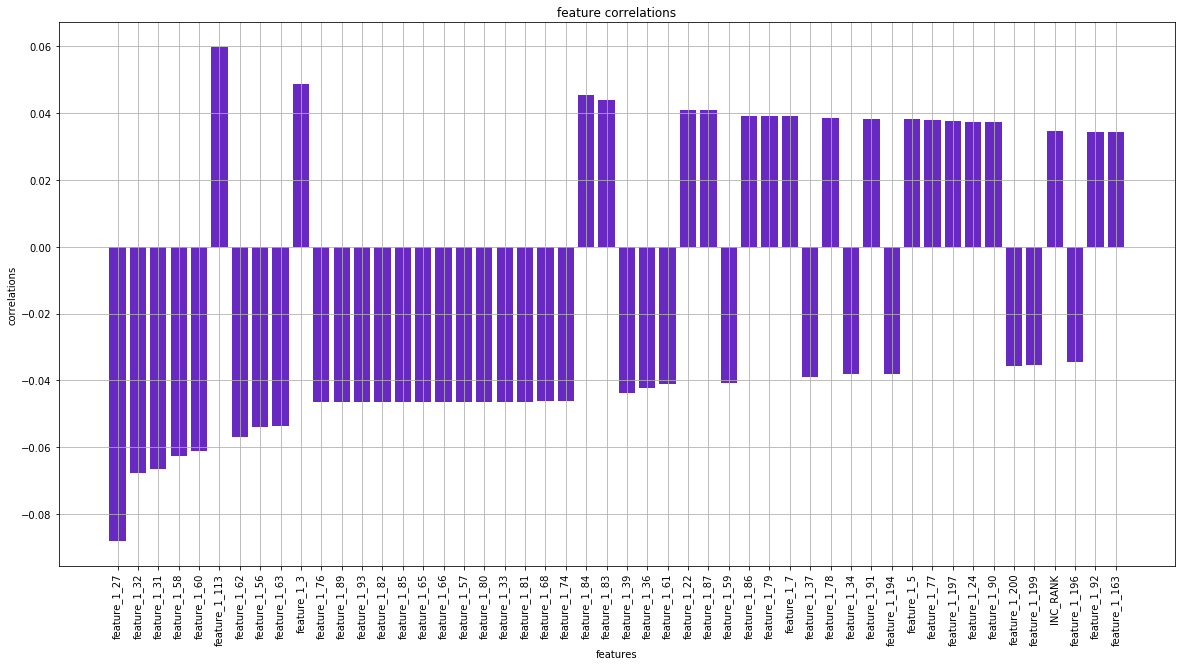

In [20]:
LENGTH=50

names, correlations = pipeline.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names[:LENGTH], correlations[:LENGTH], color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

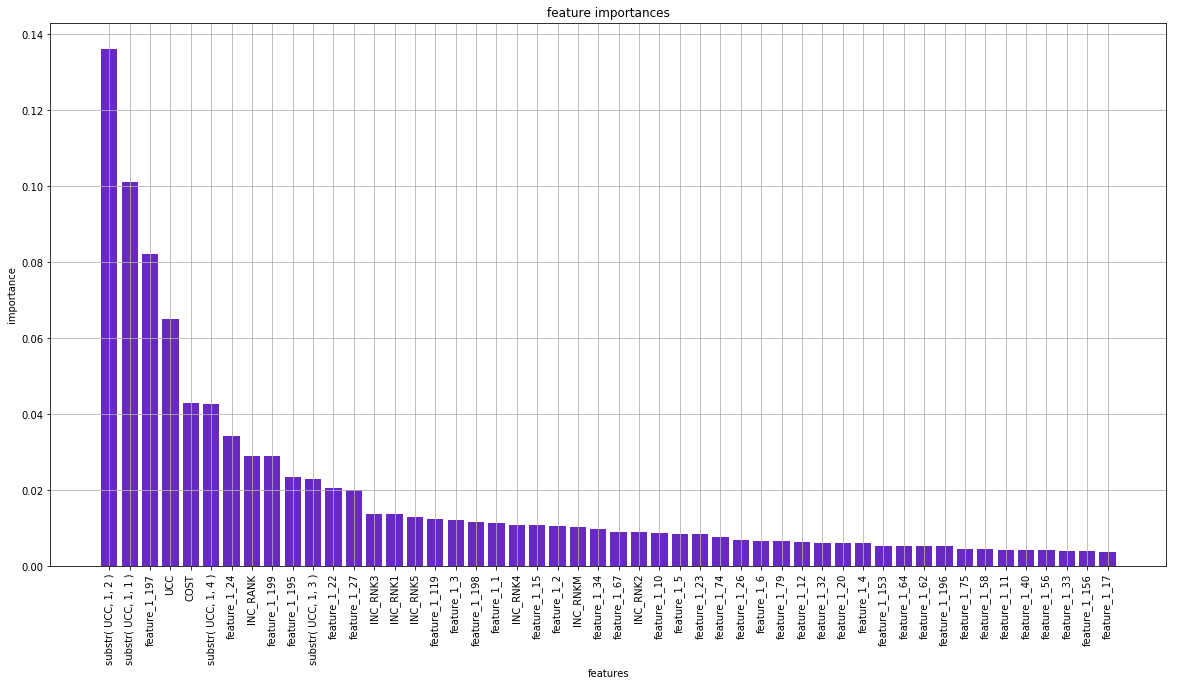

In [21]:
LENGTH=50

names, importances = pipeline.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names[:LENGTH], importances[:LENGTH], color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

We can express the features in SQLite3:

In [26]:
pipeline.features.to_sql()["feature_1_197"]

```sql
DROP TABLE IF EXISTS "FEATURE_1_197";

CREATE TABLE "FEATURE_1_197" AS
SELECT MIN( t2."AGE" ) AS "feature_1_197",
       t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "MEMD" t2
ON t1."NEWID" = t2."NEWID"
LEFT JOIN "FMLD" t3
ON t1."NEWID" = t3."NEWID"
GROUP BY t1.rowid;
```

Because getML uses a feature learning approach, the concept of feature importances can also be carried over to the individual columns.

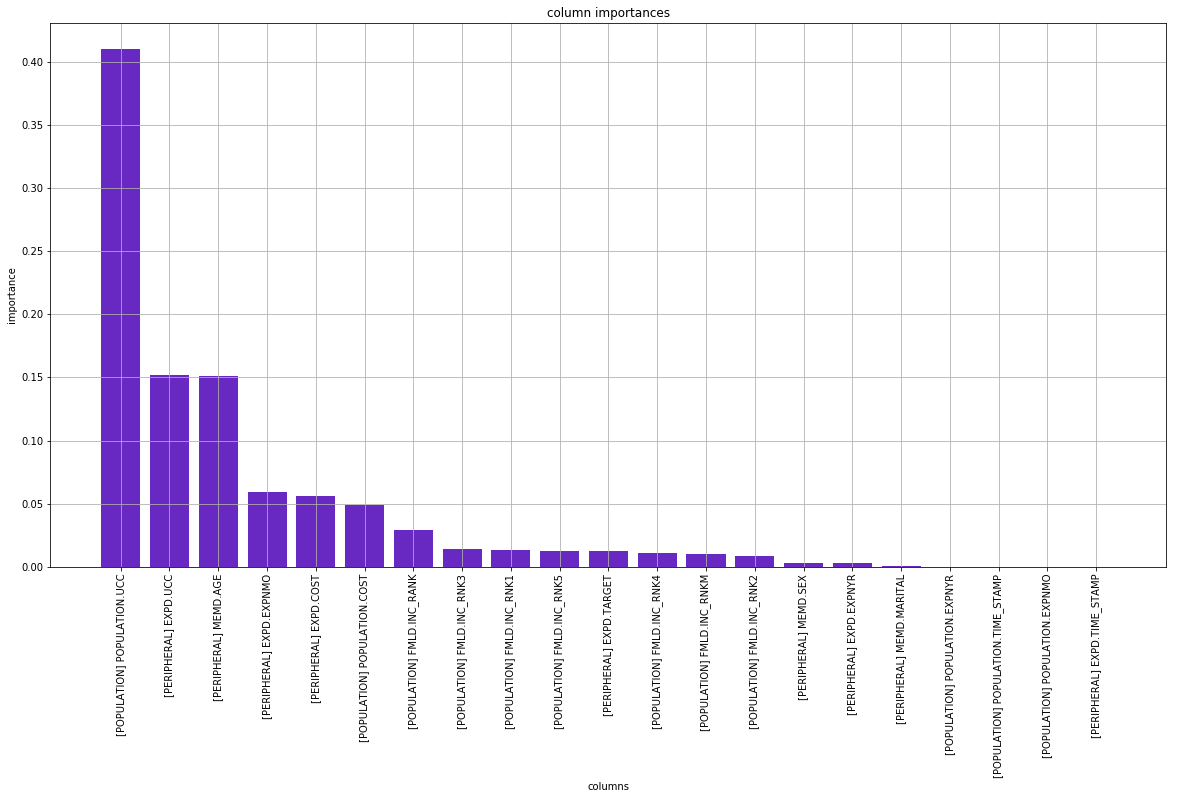

In [23]:
names, importances = pipeline.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [24]:
pipeline.columns.to_pandas()

,name,marker,table,importance,target
0,COST,[PERIPHERAL],EXPD,0.056395,TARGET
1,EXPNMO,[PERIPHERAL],EXPD,0.059103,TARGET
2,EXPNYR,[PERIPHERAL],EXPD,0.002702,TARGET
3,TARGET,[PERIPHERAL],EXPD,0.012800,TARGET
4,TIME_STAMP,[PERIPHERAL],EXPD,0.000000,TARGET
5,UCC,[PERIPHERAL],EXPD,0.151647,TARGET
6,AGE,[PERIPHERAL],MEMD,0.151280,TARGET
7,MARITAL,[PERIPHERAL],MEMD,0.000867,TARGET
8,SEX,[PERIPHERAL],MEMD,0.003352,TARGET
9,INC_RANK,[POPULATION],FMLD,0.028951,TARGET


## 3. Conclusion

In this notebook, we have shown how you can use relational learning to predict whether items were purchased as a gift. We did this to highlight the importance of relational learning. Relational learning can be used in many real-world data science applications, but unfortunately most data scientists don't even know what relation learning is.

If you want to learn more about getML, check out the [documentation](https://getml.com/product).

# Next Steps
This tutorial went through the basics of applying getML to a moderately-sized retail data set. 

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.